In [2]:
import torch
import torch.nn as nn

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
from matplotlib import pyplot as plt

In [13]:
# В данной лабораторной работе вам предстоит реализовать и обучить автокодировочную нейронную сеть.
# В этой части в качесте данных для обучения представляются сгенерированные точки на плоскости.
# Цель в том, чтобы получить интуитивное понимание того, как автокодировщик параметризует многообразие,
# в окрестности которого располагаются точки в исходном признаковом пространстве.
# Для этого данные сначала проебразуются обученным кодировщиком, а затем докодируются обратно в исходное пространство.
# В итоге все точки лежат на параметризуемом многообразии (в данном случае, некоторой кривой на плоскости).

class Encoder(nn.Module):
    # Класс кодировщика, необходимо реализовать.

    def __init__(self, inputs, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.fc1 = nn.Linear(inputs, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, latent_size)
        self.relu = nn.ReLU()
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.relu(x)
        # ============
        return x


class Decoder(nn.Module):
    # Класс декодировщика, необходимо реализовать.

    def __init__(self, latent_size, outputs):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, outputs)
        self.relu = nn.ReLU()
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # ============
        return x


def train_ae(data_loader, encoder, decoder, epochs, lr):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

    encoder.train()
    decoder.train()

    loss_history = list()

    loss_func = nn.MSELoss()  # функция потерь, нужно выбрать.
    optimizer = torch.optim.SGD(chain(encoder.parameters(), decoder.parameters()), lr=lr)  # оптимизатор, нужно выбрать.

    for epoch in tqdm(range(epochs)):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            batch=batch.to(device)
            optimizer.zero_grad()
            loss = loss_func(decoder(encoder(batch)), batch)  # потери на пакете, нужно вычислить.
            loss.backward()
            optimizer.step()
            # ============
            loss_history.append(loss.log().item())
        # print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()

In [14]:
# Создаем кодировщик и декодировщик
encoder = Encoder(2, 1)
decoder = Decoder(1, 2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
encoder=encoder.to(device)
decoder=decoder.to(device)
print('Архитектура кодировщика: ')
summary(encoder, [[2]])
print()
print('Архитектура декодировщика: ')
summary(decoder, [[1]])

cuda
Архитектура кодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           1,536
            Linear-2                  [-1, 128]          65,664
            Linear-3                    [-1, 1]             129
              ReLU-4                    [-1, 1]               0
Total params: 67,329
Trainable params: 67,329
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.26
Estimated Total Size (MB): 0.26
----------------------------------------------------------------

Архитектура декодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             256
              ReLU-2                  [-1, 128]

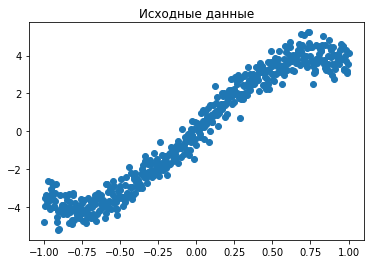

In [15]:
# Генерируем данные
x = torch.linspace(-1, 1, steps=512)
y = 4 * torch.sin(2 * x) + torch.randn(512) / 2

plt.title('Исходные данные')
plt.scatter(x, y)
plt.show()

In [16]:
# Готовим обучающие данные
train_data = torch.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
train_data_loader = DataLoader(list(zip(train_data, [torch.tensor(0)] * train_data.shape[0])), batch_size=32, shuffle=True)

100%|██████████| 500/500 [00:19<00:00, 25.70it/s]


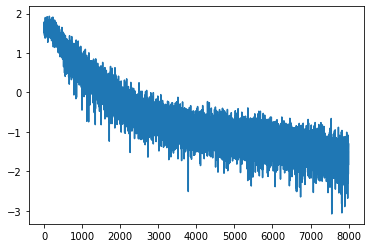

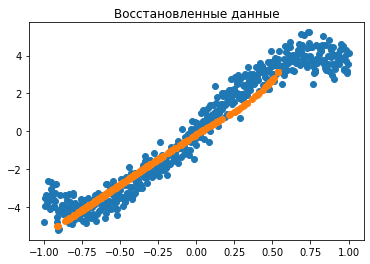

In [17]:
# Обучаем автокодировщик
train_ae(train_data_loader, encoder, decoder, 500, 5e-5)

# Прогоняем данные через автокодировщик
device="cpu"
encoder=encoder.to(device)
decoder=decoder.to(device)
restored_data = decoder(encoder(train_data))

# Отображаем результат
plt.title('Восстановленные данные')
plt.scatter(x, y)
plt.scatter(*zip(*restored_data.detach().numpy()))
plt.show()
